# Penman-Monteith Single Method Verification 

In [1]:
import os
import sys
import math
from matplotlib import pyplot as plt
from datetime import datetime
import shyft.hydrology as api
from shyft.time_series import (Calendar,deltahours,UtcPeriod,TimeSeries,TimeAxis,DoubleVector,point_interpretation_policy)

## 24-hour time-step

In [2]:
utc = Calendar() # provides shyft build-in functionality for date/time handling
# Single method test based on ASCE-EWRI Appendix C, daily time-step
# Station data: Greeley, Colorado
# Location:
latitude = 40.41
longitude = 104.78
elevation = 1462.4
# Height of measurements
height_ws = 3 # height of anemometer
height_t = 1.68 # height of air temperature and rhumidity measurements
# Vegetation info
surface_type = "irrigated grass"
height_veg = 0.12 #vegetation height, short crop
# height_veg = 0.5 #vegetation height, tall crop
# values for stomatal resistance were recalculated based on the info about bulk surface resistances and 
# equations B.3-B.6
rl = 100.8 #stomatal resistance, short crop
if height_veg>0.12:
    rl = 100.35 # tall crop
# Some calculated parameters from reference
atm_pres_mean = 85.17 #[kPa]
psychrom_const = 0.0566
windspeed_adj = 0.921
# Data for radiation model, which can be also added into calculations, so there is an option to run either with 
# measured radiation or with simulated one
lat_rad = latitude*math.pi/180
slope_deg = 0.0
aspect_deg = 0.0

In [3]:
n = 10 # nr of time steps: 1 year, daily data
t_start = utc.time(2000, 7, 1) # starting point: 1-07-2000
t_end = utc.time(2000, 7, 10, 23,0,0,0) # end point: 10-07-2000
dtdays = deltahours(24) # returns daily timestep in seconds

# First, we need a time axis, which is defined by a starting time, a time step and the number of time steps.
tadays = TimeAxis(t_start, dtdays, n) # days
period = UtcPeriod(t_start,t_end)
# print(len(tadays))

In [4]:
# Data from weather station
ws_Tmax = [32.4, 33.6, 32.6, 33.8, 32.7, 36.3, 35.5, 34.4, 32.7, 32.7] # Max air temperature, [degC]
ws_Tmin = [10.9, 12.2, 14.8, 11.8, 15.9, 15.8, 16.7, 18.3, 15.1, 15.7] # Min air temperature, [degC]
ws_ea = [1.27, 1.19, 1.40, 1.18, 1.59, 1.58, 1.13, 1.38, 1.38, 1.59]  # actual vapor pressure, [kPa]
ws_Rs = [22.4, 26.8, 23.3, 29.0, 27.9, 29.2, 23.2, 22.1, 26.5, 27.7] # Incoming shortwave radiation, [Mj/m^2/day]
ws_windspeed = [1.94, 2.14, 2.06, 1.97, 2.98, 2.37, 2.43, 1.95, 1.75, 2.31] # Windspeed, [m/s]

# Results from reference:
ET_os_daily = [5.71, 6.71, 5.98, 6.86, 7.03, 7.50, 7.03, 6.16, 6.20, 6.61] # short crop evapotranspiration
ET_rs_daily = [7.34, 8.68, 7.65, 8.73, 9.07, 9.60, 9.56, 7.99, 7.68, 8.28] # tall crop evapotranspiration
rso_d_ref = [32.43, 32.39, 32.36, 32.32, 32.27, 32.23, 32.18, 32.13, 32.08, 32.02] # simulated insolation
rnet_d_ref = [13.31, 15.20, 13.78, 16.19, 16.33, 16.83, 13.15, 13.00, 15.27, 16.15] # net radiation simulated

# conversions
c_MJm2d2Wm2 = 0.086400
c_MJm2h2Wm2 = 0.0036

In [5]:
#recalculated inputs
ws_Tmean = []
ws_rhmean = []
ws_svp_tmean = []

for i in range(len(ws_Tmax)):
    ws_Tmean.append((ws_Tmax[i]+ws_Tmin[i])*0.5)

for i in range(len(ws_Tmax)):
    ws_svp_tmean.append(0.6108 * math.exp(17.27 * ws_Tmean[i] / (ws_Tmean[i] + 237.3)))

for i in range(len(ws_Tmax)):
    ws_rhmean.append(ws_ea[i]*100/ws_svp_tmean[i])

In [6]:
# First, we convert the lists to shyft internal vectors of double values:
tempmax_dv = DoubleVector.from_numpy(ws_Tmax)
tempmin_dv = DoubleVector.from_numpy(ws_Tmin)
ea_dv = DoubleVector.from_numpy(ws_ea)
rs_dv = DoubleVector.from_numpy(ws_Rs)
windspeed_dv = DoubleVector.from_numpy(ws_windspeed)

tempmean_dv = DoubleVector.from_numpy(ws_Tmean)
rhmean_dv = DoubleVector.from_numpy(ws_rhmean)

# The TimeSeries class has some powerfull funcionality (however, this is not subject of matter in here).
# For this reason, one needs to specify how the input data can be interpreted:
# - as instant point values at the time given (e.g. such as most observed temperatures), or
# - as average value of the period (e.g. such as most observed precipitation)
# This distinction can be specified by passing the respective "point_interpretation_policy",
# provided by the API:
instant = point_interpretation_policy.POINT_INSTANT_VALUE
average = point_interpretation_policy.POINT_AVERAGE_VALUE

# Finally, we create shyft time-series as follows:
# (Note: This step is not necessarily required to run the single methods.
#  We could also just work with the double vector objects and the time axis)
tempmax_ts = TimeSeries(tadays, tempmax_dv, point_fx=instant)
tempmin_ts = TimeSeries(tadays, tempmin_dv, point_fx=instant)
ea_ts = TimeSeries(tadays, ea_dv, point_fx=instant)
rs_ts = TimeSeries(tadays, rs_dv, point_fx=instant)
windspeed_ts = TimeSeries(tadays, windspeed_dv, point_fx=instant)

#recalculated inputs:
tempmean_ts = TimeSeries(tadays, tempmean_dv, point_fx=instant)
rhmean_ts = TimeSeries(tadays, rhmean_dv, point_fx=instant)

In [7]:
land_albedo = 0.26
turbidity = 1.0 # this is a characteristic of how dusty is the air, 1 -- is clean, 0 -- dusty
radp = api.RadiationParameter(land_albedo,turbidity)
radc = api.RadiationCalculator(radp)
radr =api.RadiationResponse()

In [8]:
method_option = True # FPM
pmp=api.PenmanMonteithParameter(height_veg,height_ws,height_t,rl,method_option)
pmc=api.PenmanMonteithCalculator(pmp)
pmr =api.PenmanMonteithResponse()

method_option = False # SPM
pmpst=api.PenmanMonteithParameter(height_veg,height_ws,height_t,rl,method_option)
pmcst=api.PenmanMonteithCalculator(pmpst)
pmrst =api.PenmanMonteithResponse()

In [9]:
doy = []
day1 = 183
ET_ref_sim_d = []
ET_sim_st_d = []
rso_sim_d = []
# run simulations for 10 days
for i in range(n):
    # we call the Radiation Calculator method
    radc.net_radiation_step_asce_st(radr, latitude, tadays.time(i), deltahours(24),slope_deg, aspect_deg, tempmean_ts.v[i], rhmean_ts.v[i], elevation, rs_ts.v[i]/c_MJm2d2Wm2)
    # collect results
    rso_sim_d.append(radr.sw_cs_p*c_MJm2d2Wm2)
    # we call the SPM calculator method
    pmcst.reference_evapotranspiration(pmrst, deltahours(24),rnet_d_ref[i]/c_MJm2d2Wm2*0.0036, tempmax_ts.v[i],  tempmin_ts.v[i],  rhmean_ts.v[i], elevation,
                                             windspeed_ts.v[i]) #expected input of routine is MJ/m^2/hour
    # we call the FPM calculator method
    pmc.reference_evapotranspiration(pmr, deltahours(24),rnet_d_ref[i]/c_MJm2d2Wm2*0.0036,  tempmax_ts.v[i],  tempmin_ts.v[i], rhmean_ts.v[i], elevation,
                                               windspeed_ts.v[i])
    # collect results
    ET_ref_sim_d.append(pmr.et_ref) # the outut of et-routine now is in mm/h, here convert to mm/d
    ET_sim_st_d.append(pmrst.et_ref*24)
    # just some days control
    doy.append(day1+1)
    day1+=1

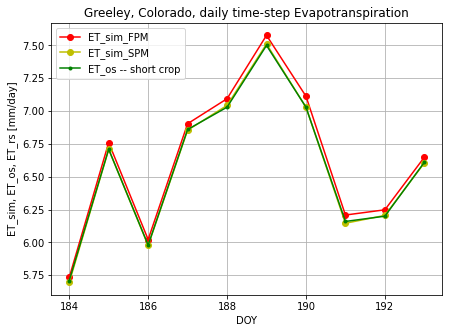

In [10]:
# Let's plot the data we received from methods
fig, ax1 = plt.subplots(figsize=(7,5))
# ax2 = ax1.twinx()
# ax1.plot(doy, rat_rad, 'g.-', label='Ratheor-integral')
ax1.plot(doy, ET_ref_sim_d, 'ro-', label='ET_sim_FPM')
ax1.plot(doy, ET_sim_st_d, 'yo-', label='ET_sim_SPM')
# ax1.plot(doy, radtheorint_arr, 'y', label='Rso')
if height_veg < 0.5:
    ax1.plot(doy, ET_os_daily, 'g.-', label='ET_os -- short crop')
else:
    ax1.plot(doy, ET_rs_daily, 'b.-', label='ET_rs -- tall crop')

ax1.set_ylabel('ET_sim, ET_os, ET_rs [mm/day]')
# ax2.set_ylabel('extraterrestrial radiation (Ra), [W/m^2]')
ax1.set_xlabel('DOY')
plt.title("Greeley, Colorado, daily time-step Evapotranspiration")
plt.legend(loc="upper left")
# plt.axis([0,365,0,10])
plt.grid(True)
plt.show()

## 1-hour timestep

In [11]:
# Single method test based on ASCE-EWRI Appendix C, hourly time-step
# height_veg = 0.12 #vegetation height, short crop
# values for stomatal resistance rl was precalculated based on the info about resistnaces and 
# nominator/denominator coefficients of the SPM
height_veg = 0.5 #tall crop
if height_veg>0.12:
    crop="tall"
    rl = 72.0 # short
else:
    crop = "short"
    rl = 66.9 #tall crop   


In [12]:
# Data from weather station
ws_Th = [30.9, 31.2, 29.1, 28.3, 26.0, 22.9, 20.1, 19.9, 18.4, 16.5, 15.4, 15.5, 13.5, 13.2, 16.2, 20.0, 22.9, 26.4, 28.2, 29.8, 30.9, 31.8, 32.5, 32.9, 32.4, 30.2, 30.6, 28.3, 25.9, 23.9]

# ws_Th_m20 = [30.9, 31.2, 29.1, 28.3, 26.0, 22.9, 20.1, 19.9, 18.4, 16.5, 15.4, 15.5, 13.5, 13.2, 16.2, 20.0, 22.9, 26.4, 28.2, 29.8, 30.9, 31.8, 32.5, 32.9, 32.4, 30.2, 30.6, 28.3, 25.9, 23.9]*0.2
ws_eah = [1.09, 1.15, 1.21, 1.21, 1.13, 1.20, 1.35, 1.35, 1.32, 1.26, 1.34, 1.31, 1.26, 1.24, 1.31, 1.36, 1.39, 1.25, 1.17, 1.03, 1.02, 0.98, 0.87, 0.86, 0.93, 1.14, 1.27, 1.27, 1.17, 1.20]
ws_Rsh = [2.24, 1.65, 0.34, 0.32, 0.08, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03, 0.46, 1.09, 1.74, 2.34, 2.84, 3.25, 3.21, 3.34, 2.96, 2.25, 1.35, 0.88, 0.79, 0.27, 0.03, 0.0]
ws_windspeedh = [4.07, 3.58, 1.15, 3.04, 2.21, 1.04, 0.58, 0.95, 0.30, 0.50, 1.00, 0.68, 0.69, 0.29, 1.24, 1.28, 0.88, 0.72, 1.52, 1.97, 2.07, 2.76, 2.90, 3.10, 2.77, 3.41, 2.78, 2.95, 3.27, 2.86]

ws_rhh = []
for i in range(len(ws_Th)):
    ws_svp_tmean = 0.6108 * math.exp(17.27 * ws_Th[i] / (ws_Th[i] + 237.3))
    ws_rhh.append(ws_eah[i]*100/ws_svp_tmean)

# print(ws_rhh)

# ET_os_h = [0.61, 0.48, 0.14, 0.22, 0.12, 0.04, 0.01, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.10, 0.19, 0.32, 0.46, 0.60, 0.72, 0.73, 0.79, 0.74, 0.62, 0.44, 0.35, 0.29, 0.17, 0.10, 0.07]
# ET_rs_h = [0.82, 0.66, 0.19, 0.35, 0.21, 0.06, 0.02, 0.04, 0.01, 0.01, 0.02, 0.01, 0.01, 0.01, 0.12, 0.23, 0.37, 0.52, 0.70, 0.85, 0.88, 0.97, 0.93, 0.81, 0.60, 0.52, 0.42, 0.29, 0.14, 0.10]
ET_os_h = [0.61, 0.48, 0.14, 0.22, 0.12, 0.04, 0.01, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.10, 0.19, 0.32, 0.46, 0.60, 0.72, 0.73, 0.79, 0.74, 0.62, 0.44, 0.35, 0.29, 0.17, 0.10]
ET_rs_h = [0.82, 0.66, 0.19, 0.35, 0.21, 0.06, 0.02, 0.04, 0.01, 0.01, 0.02, 0.01, 0.01, 0.01, 0.12, 0.23, 0.37, 0.52, 0.70, 0.85, 0.88, 0.97, 0.93, 0.81, 0.60, 0.52, 0.42, 0.29, 0.14]

# This data can be used toverify Radiation Calculator
SW_orig_h = [2.54, 1.96, 1.31, 0.63,  0.07, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04, 0.56, 1.24, 1.90, 2.49, 2.97, 3.32, 3.50, 3.51, 3.34, 3.01, 2.54, 1.96, 1.31, 0.63, 0.07]
Ra_orig_h = [3.26, 2.52, 1.68, 0.81, 0.09, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05, 0.72, 1.59, 2.43, 3.19, 3.81, 4.26, 4.49, 4.51, 4.29, 3.87, 3.26, 2.52, 1.68, 0.81, 0.09]
LW_orig_h =[0.284, 0.262, 0.017, 0.017, 0.017, 0.016, 0.015, 0.015, 0.015, 0.014, 0.014, 0.014, 0.014, 0.014, 0.014, 0.223, 0.244, 0.278, 0.299, 0.331, 0.308, 0.0332, 0.315, 0.248, 0.134, 0.084, 0.147, 0.143, 0.143]
Rnet_orig_h = [1.441, 1.009, 0.244, 0.229, 0.044, -0.016, -0.015, -0.015, -0.015, -0.014, -0.014, -0.014, -0.014, 0.009, 0.340, 0.616, 1.096, 1.524, 1.888, 2.171, 2.164, 2.239, 1.964, 1.485, 0.905, 0.593, 0.461, 0.065, -0.12]

In [13]:
# reference data is 30-hours from 1-07-2000 16.00 to 2-07-2000 21.00
nhour = 30 # nr of time steps
t_starth = utc.time(2000, 7, 1,16,0,0,0) # starting point, 1-07-2000 16.00
dthours = deltahours(1) # returns daily timestep in seconds


# Let's now create Shyft time series from the supplied lists of precipitation and temperature.
# First, we need a time axis, which is defined by a starting time, a time step and the number of time steps.
tah = TimeAxis(t_starth, dthours, nhour) # days
# print(len(tah))


# First, we convert the lists to shyft internal vectors of double values:
temph_dv = DoubleVector.from_numpy(ws_Th)
eah_dv = DoubleVector.from_numpy(ws_eah)
rsh_dv = DoubleVector.from_numpy(ws_Rsh)
windspeedh_dv = DoubleVector.from_numpy(ws_windspeedh)

rhh_dv = DoubleVector.from_numpy(ws_rhh)

# Finally, we create shyft time-series as follows:
# (Note: This step is not necessarily required to run the single methods.
#  We could also just work with the double vector objects and the time axis)
temph_ts = TimeSeries(tah, temph_dv, point_fx=instant)
eah_ts = TimeSeries(tah, eah_dv, point_fx=instant)
rsh_ts = TimeSeries(tah, rsh_dv, point_fx=instant)
windspeedh_ts = TimeSeries(tah, windspeedh_dv, point_fx=instant)


#recalculated inputs:
rhh_ts = TimeSeries(tah, rhh_dv, point_fx=instant)

In [14]:
land_albedo = 0.26
turbidity = 1.0
radph = api.RadiationParameter(land_albedo,turbidity)
radch = api.RadiationCalculator(radph)
radrh =api.RadiationResponse()

In [15]:
method_option = True # FPM
# pmph=api.PenmanMonteithParameter(lai,height_ws,height_t)
pmph=api.PenmanMonteithParameter(height_veg,height_ws,height_t, rl,method_option)
pmch=api.PenmanMonteithCalculator(pmph)
pmrh =api.PenmanMonteithResponse()

method_option = False # SPM
pmphst=api.PenmanMonteithParameter(height_veg,height_ws,height_t, rl,method_option)
pmchst=api.PenmanMonteithCalculator(pmphst)
pmrhst =api.PenmanMonteithResponse()

In [16]:
#PriestleyTaylor
ptp = api.PriestleyTaylorParameter(0.2,1.26)
ptc = api.PriestleyTaylorCalculator(0.2, 1.26)
ptr = api.PriestleyTaylorResponse

In [22]:
ET_ref_sim_h= []
ET_sim_st_h = []

timeofday = []
ET_pt_sim_h = []
Rso_sim_h = []
LW_sim_h = []
SW_sim_h = []
Ra_sim_h = []
Rnet_sim_h = []

for i in range(nhour-1):
    timeofday.append(datetime.fromtimestamp(tah.time_points[i]))
    # Radiation methods
    radch.net_radiation_step_asce_st(radrh, latitude, tah.time(i), deltahours(1),slope_deg, aspect_deg, temph_ts.v[i], rhh_ts.v[i], elevation, rsh_ts.v[i]/c_MJm2h2Wm2 )
    # collect radiation results
    Ra_sim_h.append(radrh.ra*c_MJm2h2Wm2*24 )
    Rso_sim_h.append(radrh.sw_t * c_MJm2h2Wm2)
    SW_sim_h.append(radrh.sw_t*c_MJm2h2Wm2)
    LW_sim_h.append(radrh.net_lw*c_MJm2h2Wm2)
    Rnet_sim_h.append(radrh.net * c_MJm2h2Wm2)
    # Penman-Monteith methods
    # SPM
    pmchst.reference_evapotranspiration(pmrhst,deltahours(1),Rnet_orig_h[i],temph_ts.v[i],temph_ts.v[i],rhh_ts.v[i],elevation,windspeedh_ts.v[i])
    # FPM
    pmch.reference_evapotranspiration(pmrh, deltahours(1),Rnet_orig_h[i], temph_ts.v[i],temph_ts.v[i],  rhh_ts.v[i], elevation,windspeedh_ts.v[i])
    # Collect results
    ET_ref_sim_h.append(pmrh.et_ref)
    ET_sim_st_h.append(pmrhst.et_ref)
    # ET_pt_sim_h.append(ptc.potential_evapotranspiration(temph_ts.v[i], radrh.rnet, rhh_ts.v[i]*0.01)*3600) # the PT calculates [mm/s]
    ET_pt_sim_h.append(ptc.potential_evapotranspiration(temph_ts.v[i], ws_Rsh[i]/c_MJm2h2Wm2,rhh_ts.v[i] * 0.01) * 3600)  # the PT calculates [mm/s]



MAE:0.11764318422493578


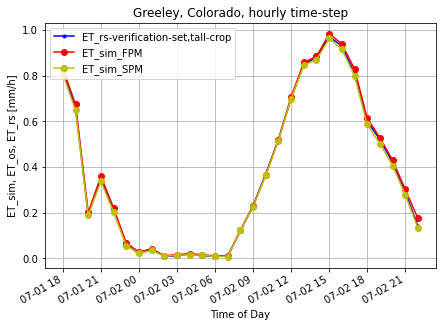

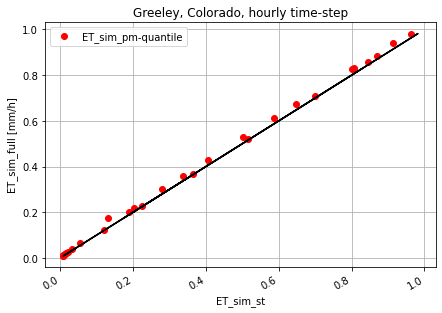

In [23]:
summary = 0
for i in range(len(ET_ref_sim_h)):
    summary+=math.fabs(ET_ref_sim_h[i]-ET_sim_st_h[i])

mae = (math.sqrt(summary/len(ET_ref_sim_h)))
print('MAE:' + str(mae))

fig, ax1 = plt.subplots(figsize=(7,5))
# ax2 = ax1.twinx()
# ax1.plot(doy, rat_rad, 'g.-', label='Ratheor-integral')
if height_veg>0.12:
    ax1.plot(timeofday, ET_rs_h, 'b.-', label='ET_rs-verification-set,'+crop+'-crop') #tall
else:
    ax1.plot(timeofday, ET_os_h, 'b.-', label='ET_os-verification-set,'+crop+' crop') #short
    
ax1.plot(timeofday, ET_ref_sim_h, 'ro-', label='ET_sim_FPM')
ax1.plot(timeofday, ET_sim_st_h, 'yo-', label='ET_sim_SPM')
# ax1.plot(doy, radtheorint_arr, 'y', label='Rso')


# ax1.plot(timeofday, ET_pt_sim_h, 'k.-', label='ET_sim_pt')

ax1.set_ylabel('ET_sim, ET_os, ET_rs [mm/h]')
# ax2.set_ylabel('extraterrestrial radiation (Ra), [W/m^2]')
ax1.set_xlabel('Time of Day')
plt.title("Greeley, Colorado, hourly time-step")
plt.legend(loc="upper left")
# plt.axis([0,365,0,10])
plt.gcf().autofmt_xdate()
plt.grid(True)
plt.show()

fig, ax1 = plt.subplots(figsize=(7,5))
ax1.plot(ET_sim_st_h, ET_ref_sim_h, 'ro', label='ET_sim_pm-quantile')
ax1.plot(ET_ref_sim_h, ET_ref_sim_h, 'k')

ax1.set_ylabel('ET_sim_full [mm/h]')
# ax2.set_ylabel('extraterrestrial radiation (Ra), [W/m^2]')
ax1.set_xlabel('ET_sim_st')
plt.title("Greeley, Colorado, hourly time-step")
plt.legend(loc="upper left")
# plt.axis([0,365,0,10])
plt.gcf().autofmt_xdate()
plt.grid(True)
plt.show()

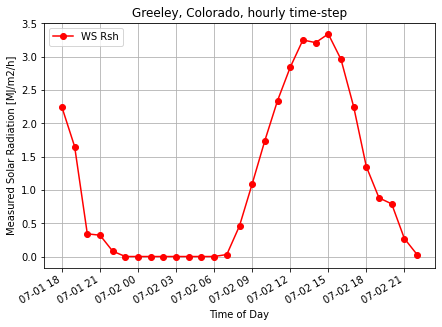

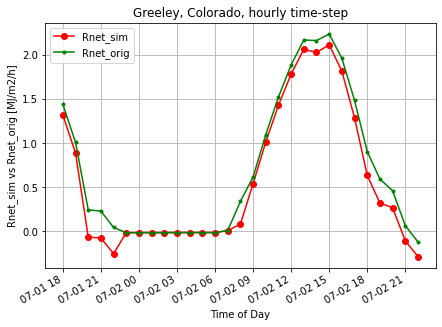

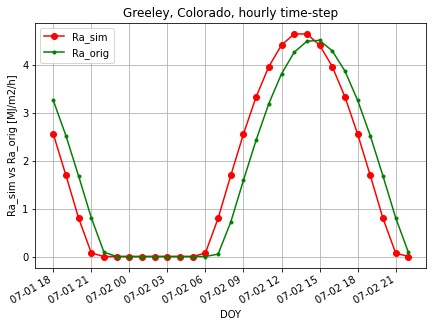

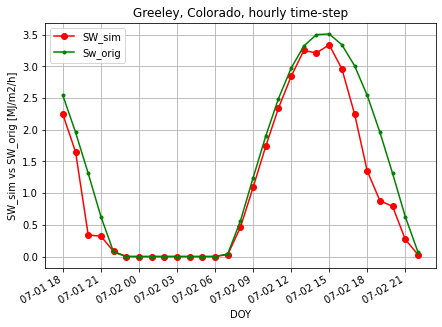

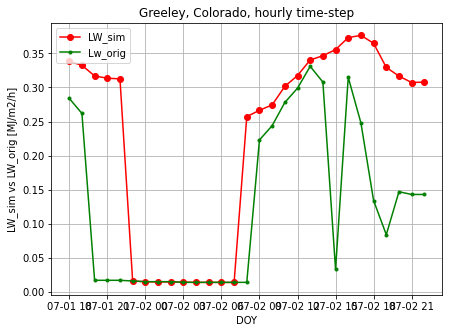

In [24]:
fig, ax1 = plt.subplots(figsize=(7,5))
ax1.plot(timeofday, ws_Rsh[0:29], 'ro-', label='WS Rsh')
# ax1.plot(timeofday, Rnet_orig_h, 'g.-', label='Rnet_orig')
ax1.set_ylabel('Measured Solar Radiation [MJ/m2/h]')
ax1.set_xlabel('Time of Day')
plt.title("Greeley, Colorado, hourly time-step")
plt.legend(loc="upper left")
# plt.axis([0,365,0,10])
plt.gcf().autofmt_xdate()
plt.grid(True)
fig, ax1 = plt.subplots(figsize=(7,5))
ax1.plot(timeofday, Rnet_sim_h, 'ro-', label='Rnet_sim')
ax1.plot(timeofday, Rnet_orig_h, 'g.-', label='Rnet_orig')
ax1.set_ylabel('Rnet_sim vs Rnet_orig [MJ/m2/h]')
ax1.set_xlabel('Time of Day')
plt.title("Greeley, Colorado, hourly time-step")
plt.legend(loc="upper left")
# plt.axis([0,365,0,10])
plt.gcf().autofmt_xdate()
plt.grid(True)
# # #
fig, ax1 = plt.subplots(figsize=(7,5))
ax1.plot(timeofday, Ra_sim_h, 'ro-', label='Ra_sim')
ax1.plot(timeofday, Ra_orig_h, 'g.-', label='Ra_orig')
ax1.set_ylabel('Ra_sim vs Ra_orig [MJ/m2/h]')
ax1.set_xlabel('DOY')
plt.title("Greeley, Colorado, hourly time-step")
plt.legend(loc="upper left")
# plt.axis([0,365,0,10])
plt.gcf().autofmt_xdate()
plt.grid(True)
# #
fig, ax1 = plt.subplots(figsize=(7,5))
# ax2 = ax1.twinx()
ax1.plot(timeofday, SW_sim_h, 'ro-', label='SW_sim')
# ax1.plot(doy, radtheorint_arr, 'y', label='Rso')
ax1.plot(timeofday, SW_orig_h, 'g.-', label='Sw_orig')
ax1.set_ylabel('SW_sim vs SW_orig [MJ/m2/h]')
ax1.set_xlabel('DOY')
plt.title("Greeley, Colorado, hourly time-step")
plt.legend(loc="upper left")
# plt.axis([0,365,0,10])
plt.gcf().autofmt_xdate()
plt.grid(True)
#
fig, ax1 = plt.subplots(figsize=(7,5))
# ax2 = ax1.twinx()
ax1.plot(timeofday, LW_sim_h, 'ro-', label='LW_sim')
# ax1.plot(doy, radtheorint_arr, 'y', label='Rso')
ax1.plot(timeofday, LW_orig_h, 'g.-', label='Lw_orig')
ax1.set_ylabel('LW_sim vs LW_orig [MJ/m2/h]')
ax1.set_xlabel('DOY')
plt.title("Greeley, Colorado, hourly time-step")
plt.legend(loc="upper left")
# plt.axis([0,365,0,10])
plt.grid(True)
